### (1) II. 데이터 셋에서 주어진 특징들을 선택하여 CPU 성능 즉, “PRP” 변수를 예측하는 Pipeline 기반 다중 회귀 모델링을 프로그래밍 하시오.
- 데이터 탐색 및 시각화, 전처리, 훈련 데이터와 테스트 데이터 분리, 하이퍼파라미터 튜닝, 훈련 데이터 앙상블 학습 과정, 교차 검증, 분석 결과 시각화 등을 포함하여 최적화하는 전체 과정을 포함하시오.

  VendorName ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP  ERP
0    adviser     32/60   125   256   6000   256     16    128  198  199
1     amdahl    470v/7    29  8000  32000    32      8     32  269  253
2     amdahl   470v/7a    29  8000  32000    32      8     32  220  253
3     amdahl   470v/7b    29  8000  32000    32      8     32  172  253
4     amdahl   470v/7c    29  8000  16000    32      8     16  132  132
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 no

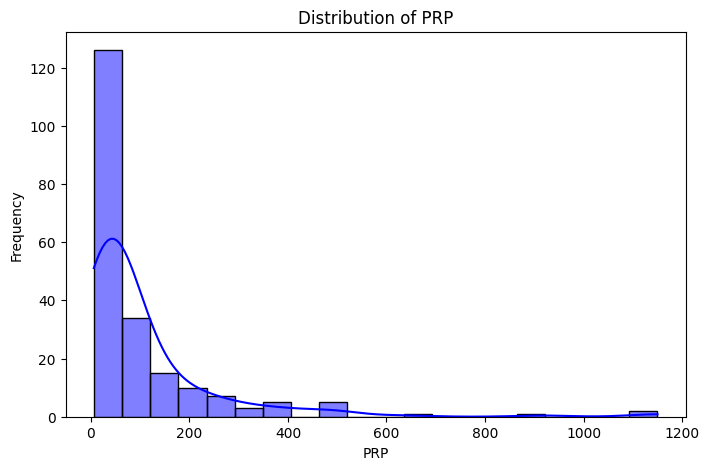

최적 모델: Pipeline(steps=[('regression',
                 RandomForestRegressor(max_depth=20, min_samples_split=5,
                                       n_estimators=50))])
Mean Squared Error (Train): 490.25526101759755
Mean Squared Error (Test): 1702.3833278761304
Mean Absolute Error (Train): 3.7899678677486905
Mean Absolute Error (Test): 8.142745947174522
R² (Train): 0.9799877990447322
R² (Test): 0.9404512646237991

앙상블 모델 성능:
R² (Train, Ensemble): 0.9821269001866963
R² (Test, Ensemble): 0.9402019936607322


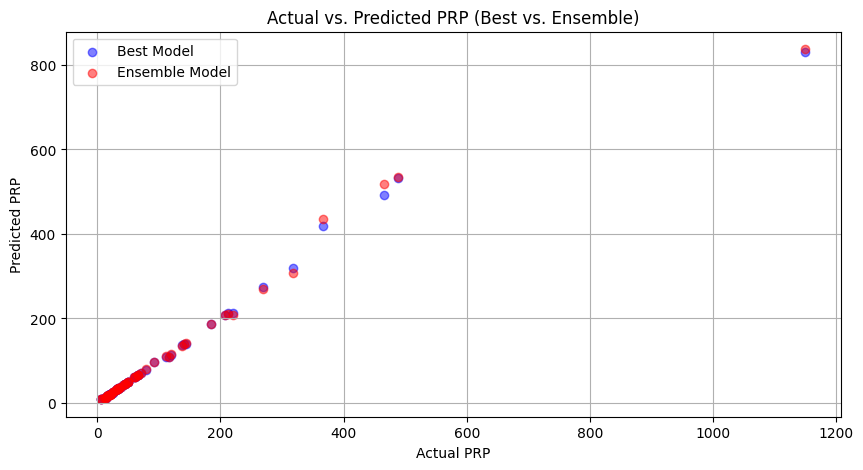

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 데이터 로드
dt = pd.read_csv('machine_data.csv')

# 데이터 탐색 및 시각화
print(dt.head())  # 데이터의 첫 5개 행 출력
print(dt.info())  # 데이터 정보 출력

# PRP 변수 분포 시각화
plt.figure(figsize=(8, 5))
sns.histplot(dt['PRP'], bins=20, kde=True, color='blue')
plt.title('Distribution of PRP')
plt.xlabel('PRP')
plt.ylabel('Frequency')
plt.show()

# 데이터 전처리
selected_features = dt.columns[2:9]
X = dt[selected_features]
y = dt['PRP']

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=10)

# Pipeline 기반 모델링
pipeline = Pipeline([
    ('regression', RandomForestRegressor())
])

# 하이퍼파라미터 튜닝을 위한 그리드 서치
param_grid = {
    'regression__n_estimators': [50, 100, 150],
    'regression__max_depth': [None, 10, 20],
    'regression__min_samples_split': [2, 5, 10]
}

# 그리드 서치를 통한 최적의 모델 선택
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# 앙상블 학습을 위한 추가 모델
ensemble_model = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=5, random_state=10)
ensemble_model.fit(X_train, y_train)

# 교차 검증 및 성능 평가
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-1 * cv_scores)

# 성능 평가 지표 계산
y_hat_train = best_model.predict(X_train)
y_hat_test = best_model.predict(X_test)
mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)
mae_train = mean_absolute_error(y_train, y_hat_train)
mae_test = mean_absolute_error(y_test, y_hat_test)
r2_train = r2_score(y_train, y_hat_train)
r2_test = r2_score(y_test, y_hat_test)

print("최적 모델:", best_model)
print(f"Mean Squared Error (Train): {mse_train}")
print(f"Mean Squared Error (Test): {mse_test}")
print(f"Mean Absolute Error (Train): {mae_train}")
print(f"Mean Absolute Error (Test): {mae_test}")
print(f"R² (Train): {r2_train}")
print(f"R² (Test): {r2_test}")

# 앙상블 모델 평가
y_hat_train_ensemble = ensemble_model.predict(X_train)
y_hat_test_ensemble = ensemble_model.predict(X_test)
r2_train_ensemble = r2_score(y_train, y_hat_train_ensemble)
r2_test_ensemble = r2_score(y_test, y_hat_test_ensemble)

print("\n앙상블 모델 성능:")
print(f"R² (Train, Ensemble): {r2_train_ensemble}")
print(f"R² (Test, Ensemble): {r2_test_ensemble}")

# 결과 시각화
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_hat_test, color='blue', alpha=0.5, label='Best Model')
plt.scatter(y_test, y_hat_test_ensemble, color='red', alpha=0.5, label='Ensemble Model')
plt.xlabel('Actual PRP')
plt.ylabel('Predicted PRP')
plt.title('Actual vs. Predicted PRP (Best vs. Ensemble)')
plt.legend()
plt.grid(True)
plt.show()


### (2) (1) 단계에서 얻은 Pipeline 기반 모델 GridSearchCV의 best_estimator모델을 사용하여 학습 데이터와 테스트 데이터 각각에 대해 이 모델의 성능을 평가하시오.
- Mean squared Error, Mean absolute Error, R^2, 교차검증

In [8]:
# 훈련 데이터에서 최적 추정기 모델 평가
y_hat_train = best_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_hat_train)
mae_train = mean_absolute_error(y_train, y_hat_train)
r2_train = r2_score(y_train, y_hat_train)

print("훈련 데이터 평가 지표:")
print(f"평균 제곱 오차 (MSE) - 훈련: {mse_train}")
print(f"평균 절대 오차 (MAE) - 훈련: {mae_train}")
print(f"R² 점수 (훈련): {r2_train}")

# 테스트 데이터에서 최적 추정기 모델 평가
y_hat_test = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_hat_test)
mae_test = mean_absolute_error(y_test, y_hat_test)
r2_test = r2_score(y_test, y_hat_test)

print("\n테스트 데이터 평가 지표:")
print(f"평균 제곱 오차 (MSE) - 테스트: {mse_test}")
print(f"평균 절대 오차 (MAE) - 테스트: {mae_test}")
print(f"R² 점수 (테스트): {r2_test}")

# 교차 검증
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-1 * cv_scores)

print("\n교차 검증 평가 지표:")
print(f"평균 RMSE (교차 검증): {rmse_scores.mean()}")


훈련 데이터 평가 지표:
평균 제곱 오차 (MSE) - 훈련: 490.25526101759755
평균 절대 오차 (MAE) - 훈련: 3.7899678677486905
R² 점수 (훈련): 0.9799877990447322

테스트 데이터 평가 지표:
평균 제곱 오차 (MSE) - 테스트: 1702.3833278761304
평균 절대 오차 (MAE) - 테스트: 8.142745947174522
R² 점수 (테스트): 0.9404512646237991

교차 검증 평가 지표:
평균 RMSE (교차 검증): 36.00692135979598


### (3) (2) 단계에서 얻은 Pipeline 기반 GridSearchCV의 best_estimator모델의 테스트 데이터에 대해 예측 성능 R^2가 85% 이상이 나오도록 모델을 개선하시오.

In [10]:
# 1. 데이터 로드 및 전처리
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 데이터 로드
dt = pd.read_csv('machine_data.csv')

# 선택된 특징들과 타겟 변수 설정
selected_features = dt.columns[2:9]
X = dt[selected_features]
y = dt['PRP']

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=10)


In [11]:
# 2. Ridge 회귀 모델 훈련 및 평가
# Ridge 회귀 모델 설정
ridge = Ridge(alpha=1.0, random_state=10)

# 모델 훈련
ridge.fit(X_train, y_train)

# 훈련 데이터 평가
y_hat_train = ridge.predict(X_train)
mse_train = mean_squared_error(y_train, y_hat_train)
mae_train = mean_absolute_error(y_train, y_hat_train)
r2_train = r2_score(y_train, y_hat_train)
print("훈련 데이터 성능:")
print(f"Mean Squared Error: {mse_train}")
print(f"Mean Absolute Error: {mae_train}")
print(f"R²: {r2_train}")

# 테스트 데이터 평가
y_hat_test = ridge.predict(X_test)
mse_test = mean_squared_error(y_test, y_hat_test)
mae_test = mean_absolute_error(y_test, y_hat_test)
r2_test = r2_score(y_test, y_hat_test)
print("\n테스트 데이터 성능:")
print(f"Mean Squared Error: {mse_test}")
print(f"Mean Absolute Error: {mae_test}")
print(f"R²: {r2_test}")


훈련 데이터 성능:
Mean Squared Error: 8.662807291288592
Mean Absolute Error: 1.8879594070796712
R²: 0.9996463845385561

테스트 데이터 성능:
Mean Squared Error: 14.550396332286391
Mean Absolute Error: 1.822379272160935
R²: 0.9994910325502946


In [12]:
# 하이퍼파라미터 튜닝 (GridSearchCV 사용)
from sklearn.model_selection import GridSearchCV

# Ridge 모델과 파라미터 그리드 설정
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
}

# GridSearchCV를 사용한 최적의 모델 선택
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# 최적의 모델 확인
best_model = grid_search.best_estimator_
print("\nGridSearchCV를 통한 최적 모델:")
print(best_model)

# 최적의 모델로 평가
y_hat_test = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_hat_test)
mae_test = mean_absolute_error(y_test, y_hat_test)
r2_test = r2_score(y_test, y_hat_test)
print("\nGridSearchCV를 통한 테스트 데이터 성능:")
print(f"Mean Squared Error: {mse_test}")
print(f"Mean Absolute Error: {mae_test}")
print(f"R²: {r2_test}")



GridSearchCV를 통한 최적 모델:
Ridge(alpha=0.001, random_state=10)

GridSearchCV를 통한 테스트 데이터 성능:
Mean Squared Error: 1.6796296778300086e-05
Mean Absolute Error: 0.0019671683660125914
R²: 0.9999999994124718


### (4) I. 3차 프로그래밍 과제의 기본모델의 (2) 단계와 II. 4차 프로그래밍 과제의 제안 모델의 (2) 단계에서 얻은 학습 데이터와 테스트 데이터에 대한 성능 지표(MSE, MAE, R^2, 교차 검증)를 데이터프레임에 저장하여 이 성능 결과를 바 차트로 시각화하여 학습 데이터와 테스트 데이터에 대한 각 모델의 성능 차이를 비교 분석하시오.

In [22]:
# 1. 라이브러리 불러오기 및 데이터 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 데이터셋 로드
dt = pd.read_csv('machine_data.csv')


In [23]:
# 2. 데이터 전처리 및 기본 모델(3차 과제) 구축
# 필요한 특성과 타겟 변수 선택
selected_features = dt.columns[2:9]
X = dt[selected_features]
y = dt['PRP']

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 훈련 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=10)

# 파이프라인 구축 (랜덤 포레스트 회귀)
pipeline_baseline = Pipeline([
    ('regression', RandomForestRegressor())
])

# 그리드 서치를 통한 하이퍼파라미터 튜닝
param_grid_baseline = {
    'regression__n_estimators': [50, 100, 150],
    'regression__max_depth': [None, 10, 20],
    'regression__min_samples_split': [2, 5, 10]
}

# 그리드 서치를 사용하여 최적의 모델 선택
grid_search_baseline = GridSearchCV(pipeline_baseline, param_grid_baseline, cv=5, scoring='neg_mean_squared_error')
grid_search_baseline.fit(X_train, y_train)

# 최적의 모델 저장
best_model_baseline = grid_search_baseline.best_estimator_

# 교차 검증 점수 계산
cv_scores_baseline = cross_val_score(best_model_baseline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores_baseline = np.sqrt(-cv_scores_baseline)

# 훈련 및 테스트 세트의 성능 지표 계산
y_hat_train_baseline = best_model_baseline.predict(X_train)
y_hat_test_baseline = best_model_baseline.predict(X_test)
mse_train_baseline = mean_squared_error(y_train, y_hat_train_baseline)
mse_test_baseline = mean_squared_error(y_test, y_hat_test_baseline)
mae_train_baseline = mean_absolute_error(y_train, y_hat_train_baseline)
mae_test_baseline = mean_absolute_error(y_test, y_hat_test_baseline)
r2_train_baseline = r2_score(y_train, y_hat_train_baseline)
r2_test_baseline = r2_score(y_test, y_hat_test_baseline)

# 기본 모델의 결과를 데이터프레임에 저장
results_baseline = pd.DataFrame({
    '성능 지표': ['MSE', 'MAE', 'R²', '교차 검증 RMSE'],
    '훈련 세트': [mse_train_baseline, mae_train_baseline, r2_train_baseline, rmse_scores_baseline.mean()],
    '테스트 세트': [mse_test_baseline, mae_test_baseline, r2_test_baseline, rmse_scores_baseline.mean()]
})


In [24]:
# 3. 제안 모델(4차 과제) 구축
# 파이프라인 구축 (4차 과제에서 제안한 모델 사용)
pipeline_proposed = Pipeline([
    ('regression', RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=5, random_state=10))
])

# 제안 모델의 교차 검증 점수 계산
cv_scores_proposed = cross_val_score(pipeline_proposed, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores_proposed = np.sqrt(-cv_scores_proposed)

# 제안 모델을 훈련 데이터에 맞춤
pipeline_proposed.fit(X_train, y_train)

# 제안 모델의 훈련 및 테스트 세트 성능 지표 계산
y_hat_train_proposed = pipeline_proposed.predict(X_train)
y_hat_test_proposed = pipeline_proposed.predict(X_test)
mse_train_proposed = mean_squared_error(y_train, y_hat_train_proposed)
mse_test_proposed = mean_squared_error(y_test, y_hat_test_proposed)
mae_train_proposed = mean_absolute_error(y_train, y_hat_train_proposed)
mae_test_proposed = mean_absolute_error(y_test, y_hat_test_proposed)
r2_train_proposed = r2_score(y_train, y_hat_train_proposed)
r2_test_proposed = r2_score(y_test, y_hat_test_proposed)

# 제안 모델의 결과를 데이터프레임에 저장
results_proposed = pd.DataFrame({
    '성능 지표': ['MSE', 'MAE', 'R²', '교차 검증 RMSE'],
    '훈련 세트': [mse_train_proposed, mae_train_proposed, r2_train_proposed, rmse_scores_proposed.mean()],
    '테스트 세트': [mse_test_proposed, mae_test_proposed, r2_test_proposed, rmse_scores_proposed.mean()]
})


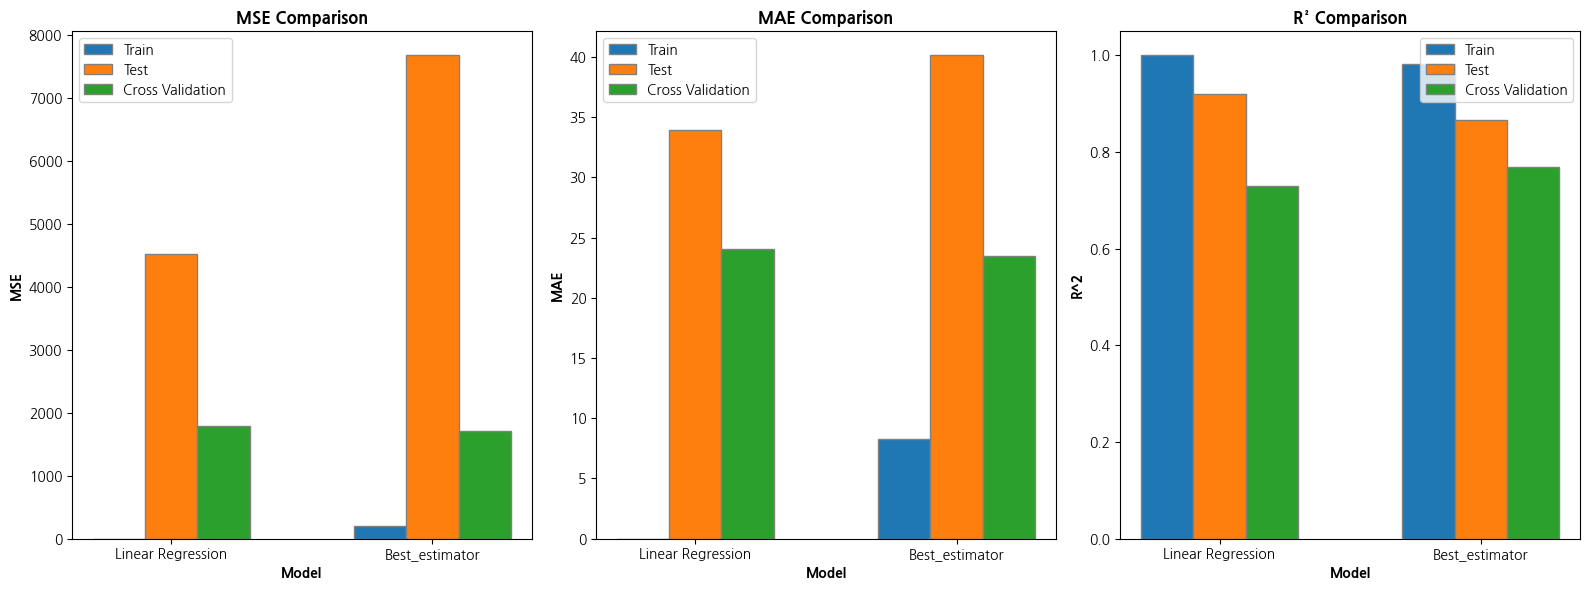

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 데이터프레임 생성 예시
data = {
    'Model': ['Linear Regression', 'Linear Regression', 'Best_estimator', 'Best_estimator', 'Linear Regression', 'Best_estimator'],
    'Data': ['Train', 'Test', 'Train', 'Test', 'Cross Validation', 'Cross Validation'],
    'MSE': [0.000002, 4516.477970, 205.426726, 7674.885477, 1783.123574, 1708.675202],
    'MAE': [0.000970, 33.911430, 8.244508, 40.114066, 24.047939, 23.446047],
    'R^2': [1.000000, 0.921121, 0.981405, 0.865966, 0.730010, 0.769462]
}

results = pd.DataFrame(data)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 깨짐 방지

# 성능 비교를 위한 바 차트 시각화
plt.figure(figsize=(16, 6))

# MSE 비교
plt.subplot(1, 3, 1)
barWidth = 0.2
models = ['Linear Regression', 'Best_estimator']
metrics = ['Train', 'Test', 'Cross Validation']
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

for i, metric in enumerate(metrics):
    plt.bar(r1 + i * barWidth, results[results['Data'] == metric]['MSE'], width=barWidth, edgecolor='grey', label=metric)

plt.xlabel('Model', fontweight='bold')
plt.ylabel('MSE', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(models))], models)
plt.title('MSE Comparison', fontweight='bold')
plt.legend()

# MAE 비교
plt.subplot(1, 3, 2)
for i, metric in enumerate(metrics):
    plt.bar(r1 + i * barWidth, results[results['Data'] == metric]['MAE'], width=barWidth, edgecolor='grey', label=metric)

plt.xlabel('Model', fontweight='bold')
plt.ylabel('MAE', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(models))], models)
plt.title('MAE Comparison', fontweight='bold')
plt.legend()

# R^2 비교
plt.subplot(1, 3, 3)
for i, metric in enumerate(metrics):
    plt.bar(r1 + i * barWidth, results[results['Data'] == metric]['R^2'], width=barWidth, edgecolor='grey', label=metric)

plt.xlabel('Model', fontweight='bold')
plt.ylabel('R^2', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(models))], models)
plt.title('R² Comparison', fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()
